# Title: Wrangling (and analyzing and visualizing) the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. 

# Table of contents
1. [Introduction](#about)
    1. [Goals](#goals)
2. [Gathering Data](#gather)
    1. [Download ](#download)
    2. [Request From Servers](#server)
    3. [Accessing API](#api)
3. [Assessing Data](#assess)
    1. [visual](#vis)
    2. [programmatic](#prog)
    3. [Quality Issues](#quality)
    4. [Tidiness Issues](#tidy)
4. [Cleaning Data](#clean)
5. [storing Data](#store)
6. [Analyzing and Visualizing](#eda)
7. [References](#ref)

    
    

## About:<a name="about"></a>
The dataset contains the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

### Goals:<a name="goals"></a>
Step 1: Gathering data

Step 2: Assessing data

Step 3: Cleaning data

Step 4: Storing data

Step 5: Analyzing, and visualizing data

## Gathering Data<a name="gather"></a>

Gather all three pieces of data from the following sources:
+ __Enhanced Twitter Archive__

The WeRateDogs Twitter archive provided contains basic tweet data for all 5000+ of their tweets including each tweet's text, rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo). Of the 5000+ tweets, there are only 2356 with ratings.

+ __Additional Data via the Twitter API__

Retweet count and favorite count are two of the notable column omissions.This additional data can be gathered  from Twitter's API and will be done for all 5000+ by querying Twitter's API.

+ __Image Predictions File__

A table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).
_NOTE_:
_tweet_id is the last part of the tweet URL after "status/",
p1 is the algorithm's #1 prediction for the image in the tweet, 
p1_conf is how confident the algorithm is in its #1 prediction,
p1_dog is whether or not the #1 prediction is a breed of dog,
p2 is the algorithm's second most likely prediction ,
p2_conf is how confident the algorithm is in its #2 prediction, 
p2_dog is whether or not the #2 prediction is a breed of dog,
etc_.

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import os
import json
import requests
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### _importing downloaded data from twitter archives into dataframe:_<a name="download"></a>

In [2]:
#twitter archive dataset
archive = pd.read_csv('twitter-archive-enhanced.csv')

### _importing data from udacity servers:_<a class="anchor" id="server"></a>

In [3]:
#neural networks dataset
#make a new folder
folder_name='image_pred'
#make new directory if does not exists
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
#create the request
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)


In [4]:
#save the contents of the response to the computer
with open(os.path.join(folder_name,url.split('/')[-1]),mode='wb') as file:
    file.write(response.content) 

In [5]:
#load the dataset into a dataframe
image_prediction = pd.read_csv(r'C:\Users\OSE\OneDrive\Desktop\DataWrangling\image_pred\image-predictions.tsv',sep ='\t')

### _downloading json file via tweepy_<a name="api"></a>

In [6]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)



__Note:json.load does not decode multiple objects so to load the json file, wrap it up in a list otherwise the error 'JSONDecodeError: Extra data:' will occur__

In [7]:
#decode json file
with open('tweet-json.txt') as json_file:
    data=[json.loads(line) for line in json_file]
    

_create a function to iterate thorugh the list of dictionaries in the json file and return a list of dictionaries containing the tweet_ids,retweet count and favourite count_

In [8]:
#create empty list
items_list=[]
#define function to iterate the dictionaries
def get_values(dict):
    '''this function loops through each dictionary
    ,extracts and stores the values for id,retweet_count
    and favorite count'''
    for key, value in dict.items():
        ids = dict["id"]
        retweet_count =dict["retweet_count"]
        favorite_count=dict["favorite_count"]
    items_list.append({"id":ids,
                      "retweet_count":retweet_count,
                      "favorite_count":favorite_count})
#iterate through the outer list
for dict in data:
    get_values(dict)
            

In [9]:
#load into dataframe
tweet_statistics = pd.DataFrame(items_list,columns=['id','retweet_count','favorite_count'])

## Assessing the data<a name="assess"></a>

+ visual assesment<a name="vis"></a>

In [10]:
archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,783214.0,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
1128,729823566028484608,NaN,NaN,2016-05-10 00:01:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stefan. He's a downright remarkable pu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/729823566...,13,10,Stefan,None,None,None,None
798,772877495989305348,NaN,NaN,2016-09-05 19:22:09 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",You need to watch these two doggos argue throu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772877495...,11,10,None,None,None,None,None


In [11]:
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [12]:
image_prediction.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
352,672538107540070400,https://pbs.twimg.com/media/CVVV1wJWoAEcOyk.jpg,1,Siamese_cat,0.383937,False,Chihuahua,0.160274,True,giant_panda,0.147745,False
1854,841077006473256960,https://pbs.twimg.com/media/C6wbE5bXUAAh1Hv.jpg,1,Brittany_spaniel,0.962985,True,Blenheim_spaniel,0.014820,True,clumber,0.009557,True


In [13]:
image_prediction.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [14]:
tweet_statistics

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


+ programmatic assesment<a name="prog"></a>

In [15]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
archive.retweeted_status_id.nunique()

181

In [17]:
sum(archive.retweeted_status_timestamp.isnull())

2175

In [18]:
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [19]:
archive.name.value_counts()


None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [20]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
tweet_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


### _Quality Issues_<a name="quality"><a/>

+ _In archive:_

1. Incorrect datatype (timestamp,tweet_id columns)
3. missing values in_reply_to_status_id,in_reply_to_user_id ,retweeted_status_id,retweeted_status_user_id and retweeted_status_timestamp columns
4. invalid dog names like a, such, getting etc. 
5. Remove retweets as original dog ratings are required.

_In image_prediction:_

5. incorrect datatype
6. Column headers should be more descriptive (i.e change img_num, p1, p1_conf, p1_dog, etc.).

_In tweet_statistics:_

7. incorrect datatype (the id datatype should be string and not integer)
8. Inconsistent column name(the  id column name does not match that of the other dataframes)

### _Tidiness Issues_<a name="tidy"></a>

+ doggo,pupper,puppo,floofer should be in a single "dog_stage" column
+ Information about one type of observational unit (tweet_id) is spread across three different files/dataframes



## Cleaning the data<a name="clean"></a>


+ __Define__

1. create copies of the archive table
1. rename the "id" column in tweet_statistics to "tweet_id" so that it can match the others
3.  replace the column names in image prediction with more descriptive names

In [22]:
archive_copy = archive.copy()
image_prediction_copy=image_prediction.copy()

In [23]:
#rename id column
tweet_statistics.rename(columns={"id":"tweet_id"}, inplace=True)
image_prediction_copy.rename(columns={'p1':"ImagePrediction_1","p1_conf":"PredictionConfidence_1","p1_dog":"accuracy_1",
                                "p2":"ImagePrediction_2","p2_conf":"PredictionConfidence_2","p2_dog":"accuracy_2",
                                "p3":"ImagePrediction_3","p3_conf":"PredictionConfidence_3","p3_dog":"accuracy_3"},inplace=True)

+ __Test__

In [24]:
tweet_statistics

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [25]:
image_prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   jpg_url                 2075 non-null   object 
 2   img_num                 2075 non-null   int64  
 3   ImagePrediction_1       2075 non-null   object 
 4   PredictionConfidence_1  2075 non-null   float64
 5   accuracy_1              2075 non-null   bool   
 6   ImagePrediction_2       2075 non-null   object 
 7   PredictionConfidence_2  2075 non-null   float64
 8   accuracy_2              2075 non-null   bool   
 9   ImagePrediction_3       2075 non-null   object 
 10  PredictionConfidence_3  2075 non-null   float64
 11  accuracy_3              2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


+ __Define__

4. remove the Nan values by dropping the 'retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp', "in_reply_to_status_id", "in_reply_to_user_id"] columns
5. convert tweet id to striing in all dataframes
6. convert timestamp datatype from string to date time
7. remove retweets by selecting only rows that have null values in retweet related columns,
8. remove invalid dog names like a, such, getting etc
9. convert None in doggo, floofer, pupper, puppo columns to null np.nan.


In [26]:
#remove invalid dog names
for index,row in archive_copy.iterrows():
    if row['name'].islower() or row['name']=="None":
        archive_copy.loc[index,'name']=archive_copy.loc[index,'name'].replace(row['name'],'')

In [27]:
#remove retweet
archive_copy = archive_copy[archive_copy.retweeted_status_id.isnull()]
archive_copy = archive_copy[archive_copy.retweeted_status_user_id.isnull()]
archive_copy = archive_copy[archive_copy.retweeted_status_timestamp.isnull()]

In [28]:
# Dropping columns with Nan Values
archive_copy = archive_copy.drop(['retweeted_status_id','retweeted_status_user_id', 
                          'retweeted_status_timestamp', "in_reply_to_status_id", "in_reply_to_user_id"],axis=1)

In [29]:
#converting tweet_id to string
archive_copy['tweet_id']=archive_copy['tweet_id'].astype('str')
image_prediction_copy['tweet_id']=image_prediction_copy['tweet_id'].astype('str')
tweet_statistics['tweet_id']=image_prediction_copy['tweet_id'].astype('str')

In [30]:
#converting timestamp to datetime
archive_copy['timestamp']=pd.to_datetime(archive_copy['timestamp'])

+ __Test__

In [31]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

In [32]:
#replace None in dogstage columns with empty string as .
archive_copy.doggo.replace('None', '', inplace=True)
archive_copy.floofer.replace('None','',inplace=True)
archive_copy.puppo.replace('None','',inplace=True)
archive_copy.pupper.replace('None','',inplace=True)


__Define(tidiness)__

9. convert doggo.puppo,pupper and floofer columns
10. merge the tables

In [33]:
#combine stage columns.
archive_copy['dog_stage'] = archive_copy.doggo + archive_copy.floofer + archive_copy.pupper + archive_copy.puppo

In [34]:
#format entries with multiple dog stages which appeared like doggopupper.

archive_copy.loc[archive_copy.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper' 
archive_copy.loc[archive_copy.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo' 
archive_copy.loc[archive_copy.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

__Test__

In [35]:
archive_copy.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
665,790698755171364864,2016-10-24 23:37:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Mosby. He appears to be rather h*ckin ...,https://twitter.com/dog_rates/status/790698755...,12,10,Mosby,,,,,
1293,708026248782585858,2016-03-10 20:26:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Everybody stop what you're doing and watch thi...,https://twitter.com/dog_rates/status/708026248...,13,10,,,,,,
1584,687096057537363968,2016-01-13 02:17:20+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This pupper's New Year's resolution was to bec...,https://twitter.com/dog_rates/status/687096057...,11,10,,,,pupper,,pupper
120,869702957897576449,2017-05-30 23:51:58+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stanley. He likes road trips. Will shift ...,https://twitter.com/dog_rates/status/869702957...,13,10,Stanley,,,,,
1921,674262580978937856,2015-12-08 16:21:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's super stoked about being an ...,https://twitter.com/dog_rates/status/674262580...,9,10,Gus,,,pupper,,pupper


In [36]:
archive_copy.dog_stage.value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

In [37]:
#remove the converted columns
archive_copy.drop(['doggo','floofer','puppo','pupper'],axis=1,inplace=True)

In [38]:
archive_copy.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
269,841320156043304961,2017-03-13 16:08:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...","We don't rate penguins, but if we did, this on...",https://twitter.com/abc/status/841311395547250688,12,10,,
470,816816676327063552,2017-01-05 01:20:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Timber. He misses Christmas. Specifica...,https://twitter.com/dog_rates/status/816816676...,12,10,Timber,


In [39]:
#change the empty rows in dogstage to nan
archive_copy.dog_stage.replace('',np.nan,inplace=True)

In [40]:
#change the empty rows in name to nan
archive_copy.name.replace('',np.nan,inplace=True)

In [41]:
#merge the arhive_copy and tweet statistics
archive_copy=pd.merge(archive_copy,tweet_statistics,left_on='tweet_id',right_on='tweet_id',how='left')

In [42]:
#merge archive copy and image pred
archive_copy=pd.merge(archive_copy,image_prediction_copy,left_on='tweet_id',right_on='tweet_id',how='left')

+ __Test__

In [43]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                2175 non-null   object             
 1   timestamp               2175 non-null   datetime64[ns, UTC]
 2   source                  2175 non-null   object             
 3   text                    2175 non-null   object             
 4   expanded_urls           2117 non-null   object             
 5   rating_numerator        2175 non-null   int64              
 6   rating_denominator      2175 non-null   int64              
 7   name                    1391 non-null   object             
 8   dog_stage               344 non-null    object             
 9   retweet_count           1994 non-null   float64            
 10  favorite_count          1994 non-null   float64            
 11  jpg_url                 1994 non-null   obj

In [44]:
sum(archive_copy.duplicated())

0

## Store Data<a name="store"></a>

In [45]:
archive_copy.to_csv('twitter_archive_master.csv',index=False)


## Analyzing and Visualizing Data<a name="eda"></a>

In [46]:
# downloading contents via url
r = requests.get(archive_copy.jpg_url[1])


In [47]:
from PIL import Image
from io import BytesIO
# storing image via memory
im = Image.open(BytesIO(r.content))

This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV


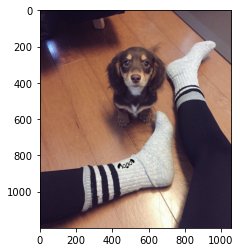

In [48]:
# displaying image
plt.imshow(im)
print(archive_copy.text[1]);

In [49]:
# copy and query only dogs
df_dog = archive_copy.copy()
df_dog = df_dog.query('accuracy_1 == True and accuracy_2 == True and accuracy_3 == True')


In [50]:
df_dog.head(3)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,img_num,ImagePrediction_1,PredictionConfidence_1,accuracy_1,ImagePrediction_2,PredictionConfidence_2,accuracy_2,ImagePrediction_3,PredictionConfidence_3,accuracy_3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,213.0,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4324.0,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,478.0,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [51]:
df_dog['accuracy_1'].value_counts()

True    1203
Name: accuracy_1, dtype: int64

In [52]:
# Query only predictions past 60%
df_dog = df_dog.query('PredictionConfidence_1 >= 0.6 or PredictionConfidence_2 >= 0.6 or PredictionConfidence_3 >= 0.6')


In [53]:
# reset the index
df_dog.reset_index(drop=True, inplace=True)

In [54]:
# this function gets only the highest prediction
def get_pred(idx, df):
    '''this function compares the values of the predictions'''
    if df.PredictionConfidence_1[idx] > df.PredictionConfidence_2[idx] or df.PredictionConfidence_1[idx] > df.PredictionConfidence_3[idx]:
        return df_dog.ImagePrediction_1[idx]

    elif df.PredictionConfidence_2[idx] > df.PredictionConfidence_1[idx] or df.PredictionConfidence_2[idx] > df.PredictionConfidence_3[idx]:
        return df_dog.ImagePrediction_2[idx]

    elif df.PredicionConfidence_3[idx] > df.PredictionConfidence_2[idx] or df.PredictionConfidence_3[idx] > df.PredictionConfidence_1[idx]:
        return df_dog.ImagePrediction_3[idx]
    else:
        return None

def display_result(rating_numerator, index):
    '''this function takes the numerator and index as arguments
    and displays the text accompanying a particular dog 
    and breed prediction'''
    dog = df_dog[df_dog.rating_numerator == rating_numerator].reset_index()
    text = dog.text[index]
    r = requests.get(dog.jpg_url[index])
    im = Image.open(BytesIO(r.content))
    pred = get_pred(index, dog)
    print(text)
    plt.imshow(im);
    print("Breed prediction: {}".format(pred))
    return dog

Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
Breed prediction: Chihuahua


,index,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,img_num,ImagePrediction_1,PredictionConfidence_1,accuracy_1,ImagePrediction_2,PredictionConfidence_2,accuracy_2,ImagePrediction_3,PredictionConfidence_3,accuracy_3
0,521,675853064436391936,2015-12-13 01:41:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an entire platoon of puppers. Tot...,https://twitter.com/dog_rates/status/675853064...,88,80,NaN,NaN,...,1.0,Labrador_retriever,0.868367,True,golden_retriever,0.043305,True,vizsla,0.028207,True


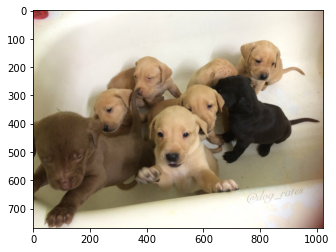

In [55]:
display_result(88,0)

This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
Breed prediction: Chihuahua


,index,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,img_num,ImagePrediction_1,PredictionConfidence_1,accuracy_1,ImagePrediction_2,PredictionConfidence_2,accuracy_2,ImagePrediction_3,PredictionConfidence_3,accuracy_3
0,0,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
1,3,889638837579907072,2017-07-25 00:10:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Ted. He does his best. Sometimes that'...,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,NaN,...,1.0,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
2,6,888917238123831296,2017-07-23 00:22:39+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Jim. He found a fren. Taught him how t...,https://twitter.com/dog_rates/status/888917238...,12,10,Jim,NaN,...,1.0,golden_retriever,0.714719,True,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True
3,8,888078434458587136,2017-07-20 16:49:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Gerald. He was just told he didn't get...,https://twitter.com/dog_rates/status/888078434...,12,10,Gerald,NaN,...,1.0,French_bulldog,0.995026,True,pug,0.000932,True,bull_mastiff,0.000903,True
4,11,887101392804085760,2017-07-18 00:07:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,10,NaN,NaN,...,1.0,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,613,668979806671884288,2015-11-24 02:29:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Chaz. He's an X Games half pipe supers...,https://twitter.com/dog_rates/status/668979806...,12,10,Chaz,NaN,...,1.0,golden_retriever,0.608537,True,Irish_setter,0.097078,True,redbone,0.076022,True
177,623,668190681446379520,2015-11-21 22:14:07+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Skittles. I would kidnap Skittles. Pin...,https://twitter.com/dog_rates/status/668190681...,12,10,Skittles,NaN,...,1.0,Blenheim_spaniel,0.958402,True,cocker_spaniel,0.026764,True,Welsh_springer_spaniel,0.007790,True
178,628,667509364010450944,2015-11-20 01:06:48+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This a Norwegian Pewterschmidt named Tickles. ...,https://twitter.com/dog_rates/status/667509364...,12,10,NaN,NaN,...,1.0,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
179,632,667435689202614272,2015-11-19 20:14:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689...,12,10,NaN,NaN,...,1.0,Rottweiler,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True


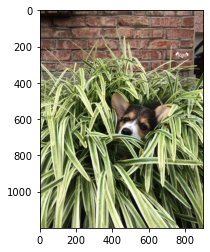

In [56]:
display_result(12,0)

the dogs with the highest rating is a group of labrador retriever puppies


In [57]:
# see unique ratings
unique_ratings= list(set(df_dog.rating_numerator))
print(unique_ratings)
    
# checking for most popular rating
for i in range(len(unique_ratings)):
    num = df_dog[df_dog.rating_numerator == unique_ratings[i]].shape[0]
    print("number of ratings {}-- {}".format(unique_ratings[i], num))

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 24, 27, 44, 60, 80, 84, 88]
number of ratings 1-- 1
number of ratings 2-- 1
number of ratings 4-- 1
number of ratings 5-- 7
number of ratings 6-- 2
number of ratings 7-- 4
number of ratings 8-- 22
number of ratings 9-- 45
number of ratings 10-- 129
number of ratings 11-- 135
number of ratings 12-- 181
number of ratings 13-- 102
number of ratings 14-- 13
number of ratings 24-- 1
number of ratings 27-- 1
number of ratings 44-- 1
number of ratings 60-- 1
number of ratings 80-- 1
number of ratings 84-- 1
number of ratings 88-- 1


<BarContainer object of 650 artists>

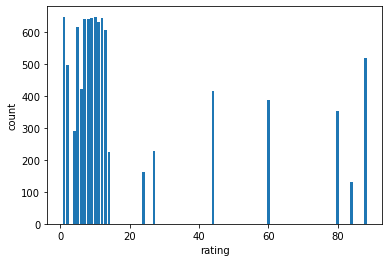

In [58]:
#popular ratings
x = list(df_dog.rating_numerator)
y = range(len(x))
plt.xlabel('rating')
plt.ylabel('count')
plt.bar(x, y)

__most dogs receive ratings bewtween 0 and 20__

Text(47.125, 0.5, 'Counts')

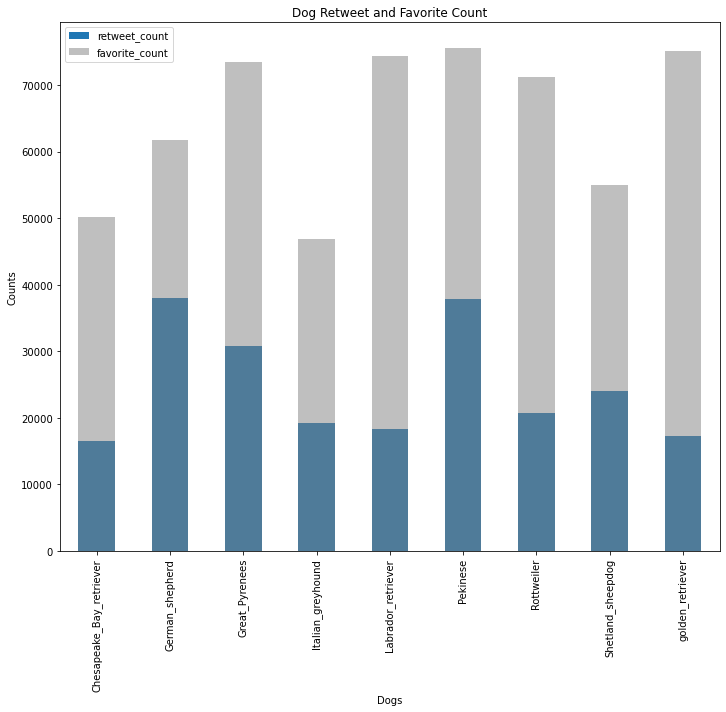

In [59]:
#highest retweet and favourite count
df_dog[df_dog.retweet_count >= 15000].groupby("ImagePrediction_1")['retweet_count'].mean().plot(kind="bar", figsize=(10, 10))
df_dog[df_dog.favorite_count >= 45000].groupby("ImagePrediction_1")['favorite_count'].mean().plot(kind="bar", figsize=(10, 10), color="grey", alpha=0.5)
plt.legend()
plt.title("Dog Retweet and Favorite Count")
plt.xlabel("Dogs")
plt.tight_layout()
plt.ylabel("Counts")

Rotweiler and German shepherd are the most retweeted dogs and Golden retriever is the dog with the higehest favourite count

In [61]:
master_archive=pd.read_csv('twitter_archive_master.csv')

In [65]:
master_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2175 non-null   int64  
 1   timestamp               2175 non-null   object 
 2   source                  2175 non-null   object 
 3   text                    2175 non-null   object 
 4   expanded_urls           2117 non-null   object 
 5   rating_numerator        2175 non-null   int64  
 6   rating_denominator      2175 non-null   int64  
 7   name                    1391 non-null   object 
 8   dog_stage               344 non-null    object 
 9   retweet_count           1994 non-null   float64
 10  favorite_count          1994 non-null   float64
 11  jpg_url                 1994 non-null   object 
 12  img_num                 1994 non-null   float64
 13  ImagePrediction_1       1994 non-null   object 
 14  PredictionConfidence_1  1994 non-null   

### Reference<a name="ref"></a>
- https://medium.com/@sambozek/ipython-er-jupyter-table-of-contents-69bb72cf39d3